Imports (**Note: install `ipywidgets` and `nodejs` in environment if they are not already**)

In [1]:
import dateutil
import itertools
import json
import pathlib

import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
sns.set_style('whitegrid')

from gurobipy import *
from ipywidgets import interact

TSP Function

In [2]:
def solve_tsp_cb(dist_df, warmstart=None, verbose=True, time_limit=None):
    """
    This function solves the travelling salesman problem for the problem defined
    by a given distance matrix. The function expects the following arguments:
    
    dist_df: a Pandas DataFrame that specifies the distance between origin-destination (OD) pairs.
    All possible values for the origin and desinatiion should be included in the index and
    columns of the DataFrame. The value at the intersection of the labels for an OD pair  
    is the distance from the origin (row label) to the destination (column label).
    
    warmstart: a list specifying a tour to use as an initial solution (optional)
    
    verbose: a flag that can be set to True or False to limit the amount of information
    from Gurobi that is written to the screen (optional)
    
    time_limit: the maximum amount of time that is allowed for Gurobi to attempt to 
    solve the problem (optional)
    
    """

    # Callback - use lazy constraints to eliminate sub-tours
    def subtourelim(model, where):
        if where == GRB.Callback.MIPSOL:
            # make a list of edges selected in the solution
            vals = model.cbGetSolution(model._vars)
            selected = tuplelist(
                (i, j) for i, j in model._vars.keys() if vals[i, j] > 0.5
            )
            # find the shortest cycle in the selected edge list
            tour = subtour(selected)
            if len(tour) < n:
                tour_sum = LinExpr()
                for tour_index, tour_stop in enumerate(tour):
                    if tour_index < len(tour) - 1:
                        tour_sum += model._vars[tour[tour_index], tour[tour_index + 1]]
                    else:
                        tour_sum += model._vars[tour[tour_index], tour[0]]
                model.cbLazy(tour_sum <= len(tour) - 1)

    # Given a list of tuples containing the tour edges, find the shortest subtour
    def subtour(edges):
        unvisited = list(dist_df.index)
        cycle = unvisited + [unvisited[0]]  # initial length has 1 more city
        while unvisited:  # true if list is non-empty
            thiscycle = []
            neighbors = unvisited
            while neighbors:
                current = neighbors[0]
                thiscycle.append(current)
                unvisited.remove(current)
                neighbors = [j for i, j in edges.select(current, "*") if j in unvisited]
            if len(cycle) > len(thiscycle):
                cycle = thiscycle
        return cycle

    # Dictionary of Euclidean distance between each pair of points
    dist = {
        (i, j): dist_df.loc[i, j]
        for i in dist_df.index
        for j in dist_df.index
        if i != j
    }

    n = len(dist_df.index)

    m = Model()
    if not verbose:
        m.params.OutputFlag = 0
    if time_limit:
        m.params.TimeLimit = time_limit
    # Create variables
    trav = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name="e")

    if warmstart:
        for warmstart_index, warmstart_stop in enumerate(warmstart):
            if warmstart_index < len(warmstart) - 1:
                trav[
                    warmstart[warmstart_index], warmstart[warmstart_index + 1]
                ].Start = 1
            else:
                trav[warmstart[warmstart_index], warmstart[0]].Start = 1
    for i in dist_df.index:
        j_sum = LinExpr()
        for j in dist_df.index:
            if j != i:
                j_sum += trav[i, j]
        m.addConstr(j_sum == 1)
    for j in dist_df.index:
        i_sum = LinExpr()
        for i in dist_df.index:
            if j != i:
                i_sum += trav[i, j]
        m.addConstr(i_sum == 1)
    # Optimize model
    m._vars = trav
    m.params.Heuristics = 0
    m.params.LazyConstraints = 1

    m.optimize(subtourelim)

    try:
        vals = m.getAttr("X", trav)
        selected = tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

        tour = subtour(selected)
        # assert len(tour) == n
        
        return [int(val) for val in tour]
    except:
        print("No solution found")

Store Data

In [3]:
data_dir = pathlib.Path('data')
data_dir.mkdir(exist_ok=True)

store_data_filepath = pathlib.Path(data_dir, 'stores.csv')

if store_data_filepath.exists():
    store_data = pd.read_csv(store_data_filepath)

store_data.head()

,store_name,state,city,zip,store_id,lat,lon
0,Manchester-Road,MO,Ballwin,63011,3004,38.6091,-90.5598
1,Ellisville,MO,Ellisville,63011,3018,38.6091,-90.5598
2,West-Frederick,MD,Frederick,21702,2511,39.4926,-77.4612
3,I-10-Bullard,LA,New-Orleans,70128,352,30.0487,-89.9585
4,Crystal-River,FL,Crystal-River,34429,6332,28.8547,-82.6669


Distance Function

In [4]:
def get_distance_data(df):

    def haversine_np(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)

        All args must be of equal length.    

        """
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

        c = 2 * np.arcsin(np.sqrt(a))
        miles = 6367 * c * 0.621371
        return miles


    store_ids = df['store_id'].unique().tolist()
    store_ids_product = list(itertools.product(store_ids, store_ids))
    dm = pd.DataFrame(store_ids_product, columns=['from', 'to'])
    lat_mapper = df.set_index('store_id')['lat'].to_dict()
    lon_mapper = df.set_index('store_id')['lon'].to_dict()
    dm['from_lat'] = dm['from'].map(lat_mapper)
    dm['from_lon'] = dm['from'].map(lon_mapper)
    dm['to_lat'] = dm['to'].map(lat_mapper)
    dm['to_lon'] = dm['to'].map(lon_mapper)
    
    lon1, lat1, lon2, lat2 = map(
        np.radians, 
        [dm['from_lon'], 
        dm['from_lat'], 
        dm['to_lon'], 
        dm['to_lat'],
        ]
    )

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    dm['miles'] = 6367 * c * 0.621371
    
    dm = dm.pivot(
        index='from',
        columns='to',
        values='miles'
    )
    
    return dm

Get Data for a Single State

In [5]:
state = 'AL'

state_df = store_data[store_data['state']==state]
state_df = state_df.reset_index(drop=True)
coordinates = state_df.set_index('store_id')[['lat', 'lon']].copy()

distance_matrix = get_distance_data(state_df)
distance_matrix.head()

to,801,802,803,804,805,806,808,809,810,812,...,877,880,881,882,883,884,887,888,6889,8577
from,,,,,,,,,,,,,,,,,,,,,
801,0.000000,36.541173,297.981664,297.771071,201.741301,164.903240,173.061772,208.679215,226.755106,308.170373,...,180.438602,219.999857,204.150350,209.672471,169.439759,278.679258,227.191134,291.166602,206.509940,290.753113
802,36.541173,0.000000,307.183587,305.724451,206.850017,161.429147,148.281529,208.563482,238.074929,313.492922,...,192.458949,225.196376,210.055336,216.886995,162.478737,289.164524,232.150208,298.766903,201.833878,305.882220
803,297.981664,307.183587,0.000000,10.642833,102.548178,159.804296,254.687934,114.185557,72.118927,34.200990,...,118.010670,85.257205,98.464305,90.637352,169.142863,21.529142,79.453052,15.455345,136.639705,51.822396
804,297.771071,305.724451,10.642833,0.000000,99.661087,155.438673,248.338485,108.716442,73.939637,24.177072,...,118.824473,81.789070,95.955546,88.843400,163.990356,27.519583,75.492069,7.404992,130.140798,62.158239
805,201.741301,206.850017,102.548178,99.661087,0.000000,59.558122,161.188466,29.889476,47.322686,106.822207,...,41.976868,18.376011,5.336426,15.168797,71.991697,87.688340,25.479859,92.488735,54.665952,117.676754


In [6]:
# state_df.to_csv('California Store Data.csv')

Solve TSP

In [7]:
tour = solve_tsp_cb(distance_matrix, verbose=False)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-29


Plot Tour

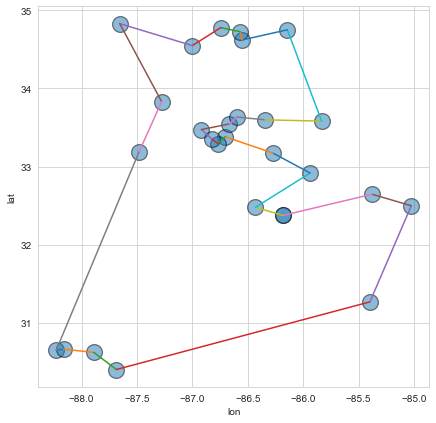

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.scatterplot(
    x='lon',
    y='lat',
    data=coordinates,
    edgecolor='k',
    alpha=0.5,
    s=250,
)

for start_index, start_customer in enumerate(tour):
    if start_customer == tour[-1]:
        next_customer = tour[0]
    else:
        next_customer = tour[start_index + 1]
        
    xs = [coordinates.loc[start_customer, 'lon'], coordinates.loc[next_customer, 'lon']]
    ys = [coordinates.loc[start_customer, 'lat'], coordinates.loc[next_customer, 'lat']]
    
    ax.plot(xs, ys)

plt.show()

Demand Data

In [9]:
demand_data_filepath = pathlib.Path(data_dir, 'demand_data.json')
with open(demand_data_filepath) as fin:
    demand_dict = json.load(fin)
    
list(demand_dict.keys())[:10]

['3004', '3018', '2511', '352', '6332', '1843', '703', '4422', '356', '4641']

Demand Data for Selected State

In [10]:
relevant_stores = state_df['store_id'].tolist()
relevant_demand = {key: val for key, val in demand_dict.items() if int(key) in relevant_stores}
relevant_demand_df = pd.DataFrame().from_dict(relevant_demand, orient='columns')
relevant_demand_df.index = pd.to_datetime(relevant_demand_df.index)
relevant_demand_df.columns = [int(val) for val in relevant_demand_df.columns]

Demand Plotting Function

In [11]:
def plot_store_demand(selected_store_id):
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    
    sns.lineplot(
        x=relevant_demand_df.index,
        y=selected_store_id,
        data=relevant_demand_df,
    )
    
    plt.show()

Interactive Demand Visualization

In [12]:
interact(plot_store_demand, selected_store_id=relevant_stores);

interactive(children=(Dropdown(description='selected_store_id', options=(875, 882, 883, 813, 805, 802, 8577, 8…

OM 501<br>
Vehicle Routing Project Guidelines<br>
DUE DATE: December 4 (wednesday), 2022 @ 6:30pm - 8:30pm.<br>

Description:
The purpose of this team project is to design, construct, and use a Python application that is capable of solving a capacitated vehicle routing problem with multiple demand points and suggesting a distribution strategy for a subset of U.S. states. For the purpose of this project, a distribution strategy specifies: 
- how many distribution centers (DCs) to open, 
- where to open them, 
- the customer assigned to each DC,
- and data insights to support your recommendation.

The data you will be using is based on Home Depot locations in the states of California (CA), Texas (TX), and Alabama (AL). You will be determining solutions for each state.
Problem assumptions are: 
- Home Depot distributes goods to "customer" stores using a single DC and makes weekly shipments.
- Home Depot considers each state separately, i.e., DCs in AL ship only to stores in AL, 
- Demand is given in pounds. Essentially, we are assuming that the products are "heavy", thus, when shipping, we are more constrained by weight rather than volume.
- You have access to vehicles that can haul 40,000 in each trip.

Presentations:
Each team will give a 20 minute presentation detailing their approach to the problem, along with their results for each state and any justification.

## First, let's try one distribution center.

In [11]:
state_cluster = pd.read_csv('Texas Clusters.csv')

In [12]:
state_df = pd.merge(state_df, state_cluster, how = 'left', left_on = ['lat','lon'], right_on = ['lat','lon'])

In [13]:
state_df

,store_name,state,city,zip,store_id,lat,lon,Clusters
0,Tomball,TX,Houston,77070,6512,29.9781,-95.5803,Cluster 2
1,White-Rock,TX,Dallas,75218,550,32.8463,-96.6972,Cluster 1
2,Keller,TX,Keller,76248,6548,32.9276,-97.2489,Cluster 1
3,Beaumont,TX,Beaumont,77703,501,30.1132,-94.1197,Cluster 2
4,Mckinney,TX,Mckinney,75070,528,33.1976,-96.6153,Cluster 1
...,...,...,...,...,...,...,...,...
174,Weslaco,TX,Weslaco,78599,6577,26.1595,-97.9908,Cluster 2
175,Carrollton,TX,Carrollton,75006,6555,32.9657,-96.8825,Cluster 1
176,Woodlands,TX,Conroe,77385,6516,30.1877,-95.4288,Cluster 2
177,Brenham-TX,TX,Brenham,77833,8518,30.1774,-96.4028,Cluster 2


In [14]:
filter = state_df['Clusters'] == 'Cluster 1'
cluster1 = state_df.loc[filter, :]

In [15]:
cluster1

,store_name,state,city,zip,store_id,lat,lon,Clusters
1,White-Rock,TX,Dallas,75218,550,32.8463,-96.6972,Cluster 1
2,Keller,TX,Keller,76248,6548,32.9276,-97.2489,Cluster 1
4,Mckinney,TX,Mckinney,75070,528,33.1976,-96.6153,Cluster 1
9,N-Frisco,TX,Frisco,75033,6513,33.2559,-96.8853,Cluster 1
12,Precinct-Line,TX,North-Richland-Hills,76182,6533,32.8828,-97.2098,Cluster 1
...,...,...,...,...,...,...,...,...
168,Flower-Mound,TX,Flower-Mound,75022,6572,33.0268,-97.1193,Cluster 1
169,Texarkana,TX,Texarkana,75503,6580,33.4669,-94.0774,Cluster 1
170,Corsicana,TX,Corsicana,75109,6817,31.9937,-96.4199,Cluster 1
172,Mansfield-TX,TX,Mansfield,76063,6568,32.5773,-97.1416,Cluster 1


In [16]:
n = len(cluster1)
xc = list(cluster1['lat'])
yc = list(cluster1['lon'])

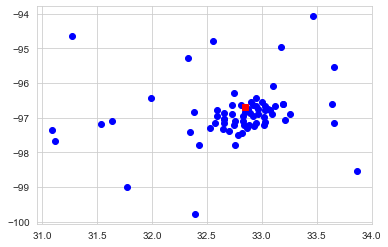

In [17]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

Avg Capacity of Stores

In [18]:
relevant_stores = cluster1['store_id'].tolist()
relevant_demand = {key:val for key, val in demand_dict.items() if int(key) in relevant_stores}
relevant_demand_df = pd.DataFrame().from_dict(relevant_demand, orient='columns')
relevant_demand_df.loc['mean_demand'] = relevant_demand_df.mean()
relevant_demand_df = relevant_demand_df.T['mean_demand']
relevant_demand_df = pd.DataFrame(relevant_demand_df)

In [19]:
n = len(cluster1)

In [20]:
N = [i for i in range(1, n)]   # set of relevant stores
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]   # all possible paths
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}   # distance of each path
Q = 40000  # Truck Capacity
q = relevant_demand_df['mean_demand'].tolist()   # store demands

In [21]:
from gurobipy import *

In [22]:
mdl = Model('CVRP')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-29


In [23]:
x = mdl.addVars(A, vtype=GRB.BINARY)   # 1 if path is chosen
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)   # stuff needed in a truck for each store

In [24]:
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A))

In [25]:
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)   
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)   # every node has 2 vertices
mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])   # stuff in truck plus next stores demand equals next stores needed truck stuff
               for i, j in A if i != 0 and j != 0)
mdl.addConstrs(u[i] >= q[i] for i in N)   # stuff in truck is greater than or equal to store's demand
mdl.addConstrs(u[i] <= Q for i in N)   # stuff in truck less than truck capacity

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

In [26]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 30  # seconds
mdl.optimize()

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 280 rows, 5040 columns and 9940 nonzeros
Model fingerprint: 0xc06e64c6
Model has 4830 general constraints
Variable types: 70 continuous, 4970 integer (4970 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
  GenCon rhs range [2e+02, 6e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 4690 rows and 4830 columns
Presolve time: 0.06s
Presolved: 4970 rows, 9870 columns, 21875 nonzeros
Presolved model has 4830 SOS constraint(s)
Variable types: 4900 continuous, 4970 integer (4970 binary)
Found heuristic solution: objective 101.5749770

Root relaxation: objective 1.953080e+01, 141 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current No

In [27]:
active_arcs = [a for a in A if x[a].x > 0.99]

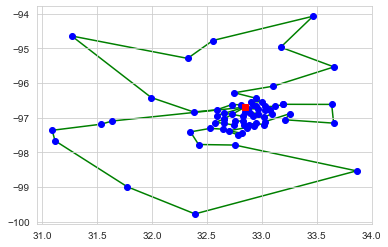

In [28]:
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

In [29]:
active_arcs

[(0, 16),
 (0, 43),
 (1, 56),
 (2, 51),
 (3, 66),
 (4, 42),
 (5, 1),
 (6, 55),
 (7, 57),
 (8, 33),
 (9, 3),
 (10, 70),
 (11, 34),
 (12, 37),
 (13, 11),
 (14, 6),
 (15, 69),
 (16, 15),
 (17, 53),
 (18, 48),
 (19, 13),
 (20, 9),
 (21, 22),
 (22, 68),
 (23, 21),
 (24, 0),
 (25, 62),
 (26, 30),
 (27, 14),
 (28, 59),
 (29, 7),
 (30, 10),
 (31, 24),
 (32, 2),
 (33, 50),
 (34, 40),
 (35, 38),
 (36, 58),
 (37, 52),
 (38, 31),
 (39, 45),
 (40, 28),
 (41, 20),
 (42, 5),
 (43, 23),
 (44, 61),
 (45, 54),
 (46, 64),
 (47, 35),
 (48, 63),
 (49, 60),
 (50, 67),
 (51, 41),
 (52, 0),
 (53, 36),
 (54, 12),
 (55, 32),
 (56, 17),
 (57, 26),
 (58, 18),
 (59, 29),
 (60, 27),
 (61, 4),
 (62, 47),
 (63, 25),
 (64, 39),
 (65, 49),
 (66, 44),
 (67, 19),
 (68, 8),
 (69, 46),
 (70, 65)]